In [32]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install netcal
!pip install scikit-learn

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netcal.presentation import ReliabilityDiagram

In [35]:
def binary_cost(predictions, labels):
    # true(no cancer, cancer) vs observed(non cancer, cancer)
    cost_matrix = np.array([[0, 100],
                           [0, 0]])
    cost_dict = {}

    for index in range(11):
      threshold = cost_matrix[0][1]/(cost_matrix[0][1] + cost_matrix[1][0])
      cost = 0
      for index in range(len(predictions)):
          if predictions[index] > threshold:
             cost += (cost_matrix[labels[index]][1])
          else:
             cost += (cost_matrix[labels[index]][0])
      cost_dict[threshold] = cost/len(predictions)
      cost_matrix[0, 1] -= 10
      cost_matrix[1, 0] += 10
    return cost_dict



In [36]:
predictions = np.array([0.9])
labels = np.array([0])
print("false positive: " + str(binary_cost(predictions, labels)))

predictions = np.array([0.1])
labels = np.array([1])
print("false negative: " + str(binary_cost(predictions, labels)))

false positive: {1.0: 0.0, 0.9: 0.0, 0.8: 80.0, 0.7: 70.0, 0.6: 60.0, 0.5: 50.0, 0.4: 40.0, 0.3: 30.0, 0.2: 20.0, 0.1: 10.0, 0.0: 0.0}
false negative: {1.0: 0.0, 0.9: 10.0, 0.8: 20.0, 0.7: 30.0, 0.6: 40.0, 0.5: 50.0, 0.4: 60.0, 0.3: 70.0, 0.2: 80.0, 0.1: 90.0, 0.0: 0.0}


In [37]:
def evaluate_cost(filename):
    csv_file = pd.read_csv(filename)
    labels = csv_file["label"].to_numpy()
    predictions = csv_file["prediction"].to_numpy()
    total_cost_dict = binary_cost(predictions, labels)
    return total_cost_dict

In [38]:
filenames = {"ISIC CNN No Calibration":                         "/content/drive/MyDrive/Outputs/isic_cnn_ISIC_none.csv",
                   "ISIC CNN Temperature Scaling":                    "/content/drive/MyDrive/Outputs/isic_cnn_ISIC_temperature_False.csv",
                   "ISIC CNN Temperature Scaling at Boundry":         "/content/drive/MyDrive/Outputs/isic_cnn_ISIC_temperature_True.csv"
                   }

[0 1]
[3287 1728]


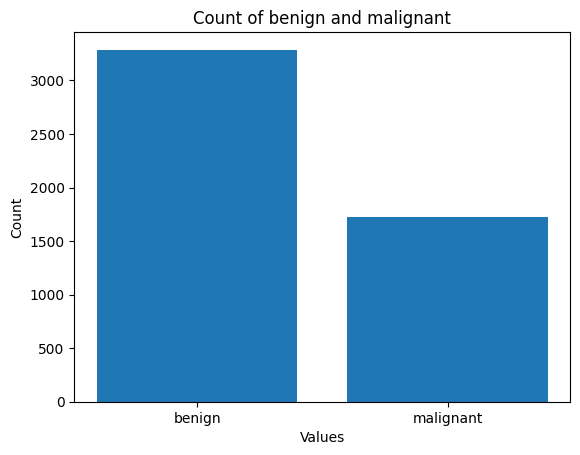

In [39]:
categories= ["benign", "malignant"]
csv_file = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_none.csv")
labels = csv_file["label"].to_numpy()
unique, counts = np.unique(labels, return_counts=True)
print(unique)
print(counts)

plt.bar(categories, counts)

# Add labels and title
plt.xlabel("Values")
plt.ylabel("Count")
plt.title("Count of benign and malignant")

# Show the plot
plt.show()

In [40]:
dict_list = []
for file, path in filenames.items():
    dict_list.append(evaluate_cost(path))


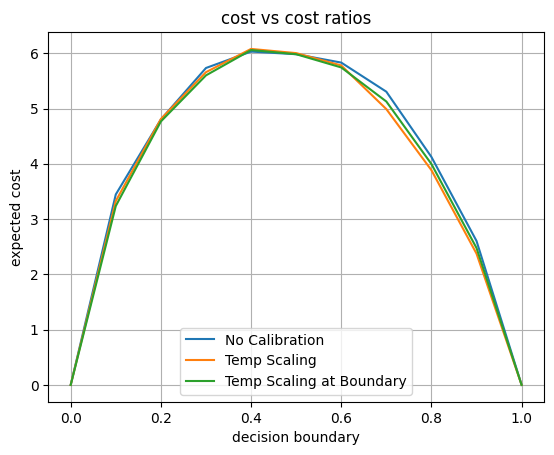

In [41]:
for cost_dict, label in zip(dict_list, ["No Calibration", "Temp Scaling", "Temp Scaling at Boundary"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    plt.plot(x_values, y_values, label=label)
plt.xlabel("decision boundary")
plt.ylabel("expected cost")
plt.title("cost vs cost ratios")
plt.legend()
plt.grid(True)
plt.show()


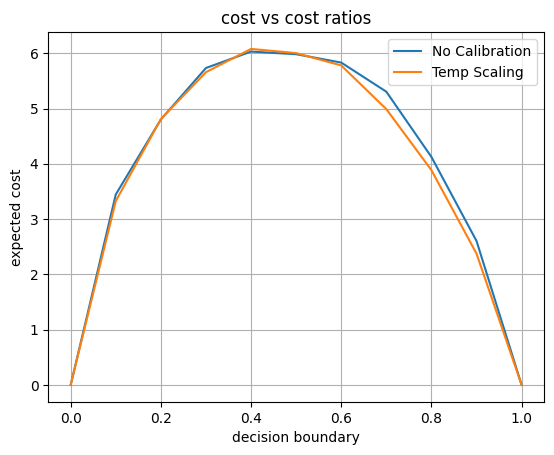

In [42]:
for cost_dict, label in zip([dict_list[0],dict_list[1]], ["No Calibration", "Temp Scaling"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    plt.plot(x_values, y_values, label=label)
plt.xlabel("decision boundary")
plt.ylabel("expected cost")
plt.title("cost vs cost ratios")
plt.legend()
plt.grid(True)
plt.show()

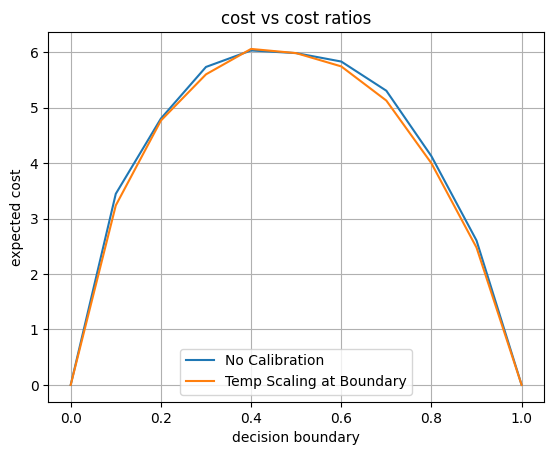

Sum E(cost)
no calibration: 43.8544366899302
constrained scaling: 42.983050847457626


In [43]:
for cost_dict, label in zip([dict_list[0],dict_list[2]], ["No Calibration", "Temp Scaling at Boundary"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    plt.plot(x_values, y_values, label=label)
plt.xlabel("decision boundary")
plt.ylabel("expected cost")
plt.title("cost vs cost ratios")
plt.legend()
plt.grid(True)
plt.show()

print("Sum E(cost)" + "\n" + "no calibration: " + str(sum(dict_list[0].values())) + "\n" + "constrained scaling: " +  str(sum(dict_list[2].values())))

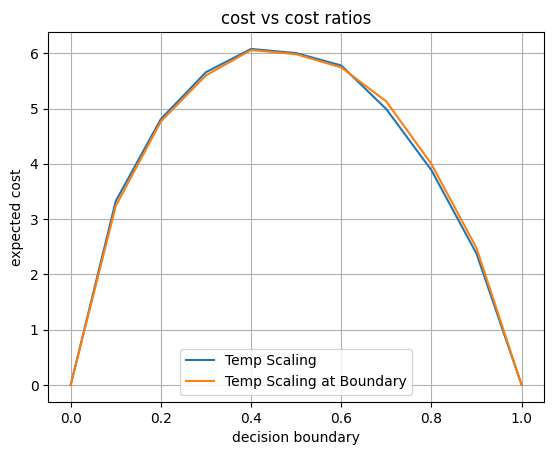

In [44]:
for cost_dict, label in zip([dict_list[1],dict_list[2]], ["Temp Scaling", "Temp Scaling at Boundary"]):
    x_values = list(cost_dict.keys())
    y_values = list(cost_dict.values())
    plt.plot(x_values, y_values, label=label)
plt.xlabel("decision boundary")
plt.ylabel("expected cost")
plt.title("cost vs cost ratios")
plt.legend()
plt.grid(True)
plt.show()


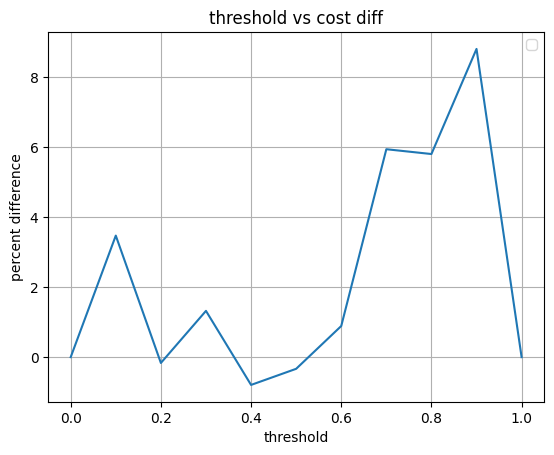

In [45]:
cost_dict_none = dict_list[0]
cost_dict_boundary = dict_list[1]
percent_decrease = []
# we expect the cost dictionary to be of the same length and of the same order.
for val_none, val_boundary in zip(cost_dict_none.values(), cost_dict_boundary.values()):
  if val_none ==0 and val_boundary == 0:
    percent_decrease.append(0)
  elif val_none == 0 and val_boundary != 0:
    percent_decrease.append(100) #magic, if we see 100, thats a problem
  else:
    percent_decrease.append((((val_none - val_boundary)/ val_none))*100)


plt.plot(cost_dict.keys(), percent_decrease)
plt.xlabel("threshold")
plt.ylabel("percent difference")
plt.title("threshold vs cost diff")
plt.legend()
plt.grid(True)
plt.show()


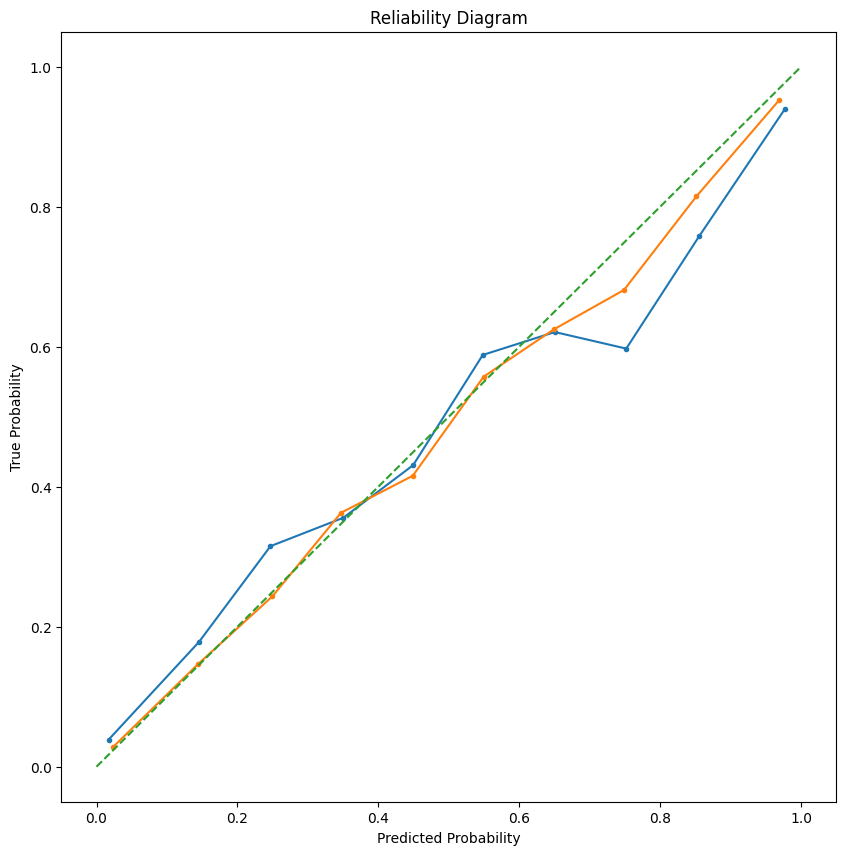

In [46]:
from sklearn.calibration import calibration_curve

csv_file_1 = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_none.csv")
labels_1 = csv_file["label"].to_numpy()
predictions_1 = csv_file["prediction"].to_numpy()

# Compute the calibration curve
prob_true, prob_pred = calibration_curve(labels_1, predictions_1, n_bins=10)

# Create the reliability diagram
plt.figure(figsize=(10, 10))
plt.plot(prob_pred, prob_true, marker='.')
csv_file_2 = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_temperature_True.csv")
labels_2 = csv_file_2["label"].to_numpy()
predictions_2 = csv_file_2["prediction"].to_numpy()

prob_true_2, prob_pred_2 = calibration_curve(labels_2, predictions_2, n_bins=10)
plt.plot(prob_pred_2, prob_true_2, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Reliability Diagram')
plt.show()




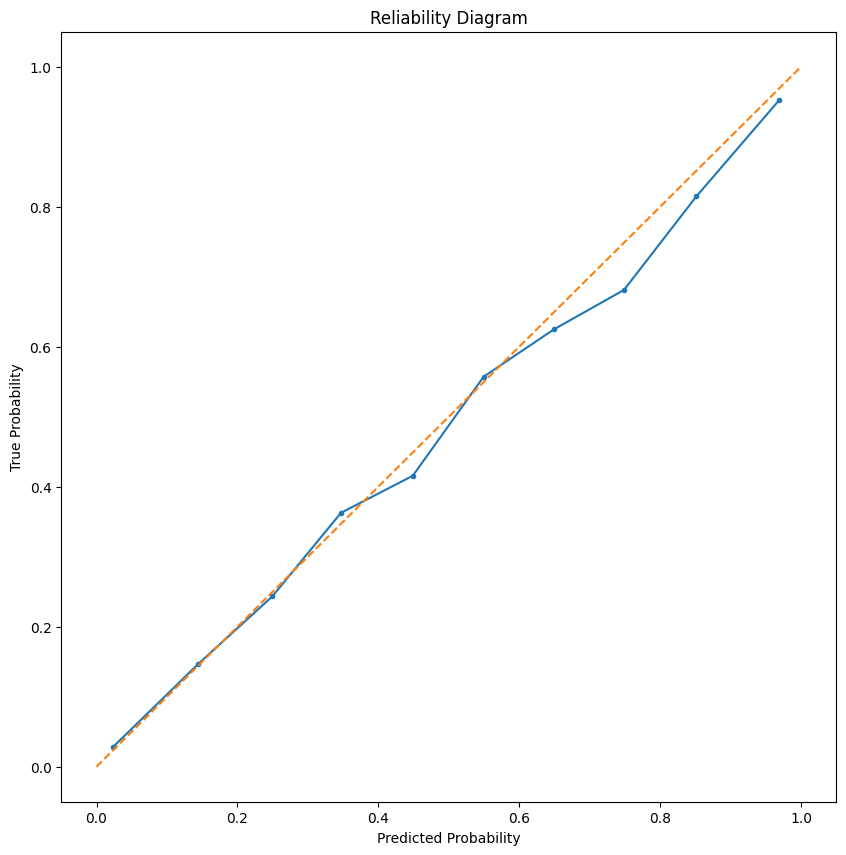

In [47]:
csv_file_2 = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_temperature_True.csv")
labels_2 = csv_file_2["label"].to_numpy()
predictions_2 = csv_file_2["prediction"].to_numpy()

prob_true_2, prob_pred_2 = calibration_curve(labels_2, predictions_2, n_bins=10)
plt.figure(figsize=(10, 10))
plt.plot(prob_pred_2, prob_true_2, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Reliability Diagram')
plt.show()

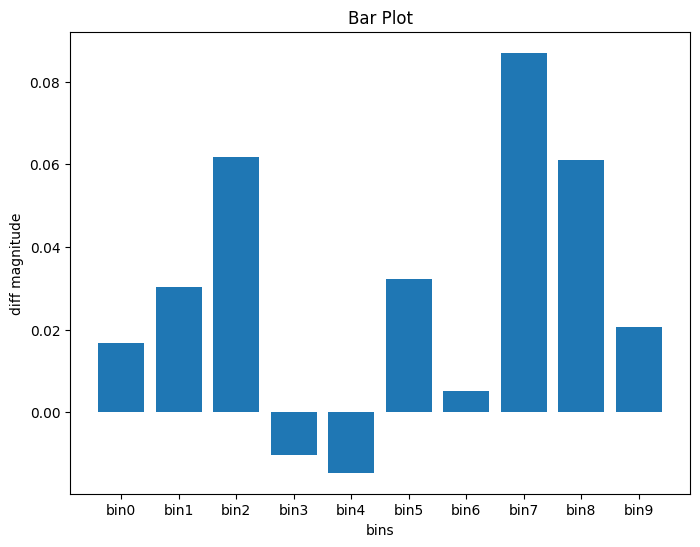

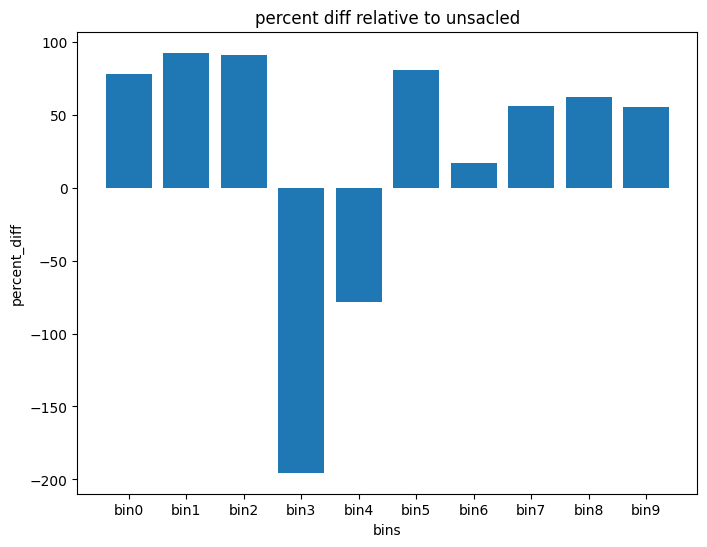

In [63]:
csv_file_2 = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_temperature_True.csv")
labels_2 = csv_file_2["label"].to_numpy()
predictions_2 = csv_file_2["prediction"].to_numpy()

csv_file_1 = pd.read_csv("/content/drive/MyDrive/Outputs/isic_cnn_ISIC_none.csv")
labels_1 = csv_file["label"].to_numpy()
predictions_1 = csv_file["prediction"].to_numpy()

prob_true_1, prob_pred_1 = calibration_curve(labels_1, predictions_1, n_bins=10)
prob_true_2, prob_pred_2 = calibration_curve(labels_2, predictions_2, n_bins=10)

diff = []
percent_diff = []
bins = []
for index in range(10):
  diff_1 = (abs(prob_pred_1[index] - prob_true_1[index]))
  diff_2 = (abs(prob_pred_2[index] - prob_true_2[index]))
  percent_diff.append(((diff_1 - diff_2)/diff_1)*100 )
  diff.append(diff_1 - diff_2)
  bins.append(f'bin{index}')

plt.figure(figsize=(8, 6))
plt.bar(bins, diff)
plt.xlabel('bins')
plt.ylabel('diff magnitude')
plt.title('Bar Plot')
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(bins, percent_diff)
plt.xlabel('bins')
plt.ylabel('percent_diff')
plt.title('percent diff relative to unscaled')
plt.show()

